In [402]:
import pandas as pd
import numpy as np
import json
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Load tree and sequence files
with open('auspice/flu_seasonal_h3n2_ha_6y_tree.json', 'r') as jsonfile:
    tree_6y = json.load(jsonfile)

with open('auspice/flu_seasonal_h3n2_ha_6y_sequences.json', 'r') as jsonfile:
    seq_6y = json.load(jsonfile)

In [177]:
#Load genbank file with reference HA sequence
for seq_record in SeqIO.parse('h3n2_outgroup.gb', 'genbank'):
    SP_ref = seq_record.seq[0:49].translate()
    HA1_ref = seq_record.seq[48:1035].translate()
    HA2_ref = seq_record.seq[1035:1699].translate()

In [206]:
#Input desired 0-based HA1 amino acid residue positions, find reference amino acid

positions = [159,185,193,224,218]
position_refaa = []

for pos in positions:
    position_refaa.append((str(pos), HA1_ref[pos]))


In [207]:
#Pull out tree tips from tree.json and HA1 muts (not just tip-specific) from sequences.json
#Generalize for any aa position, by entering position and ref AA as tuple

    
tip_muts = {}

def traverse(branch, seq, pos_list):

    if 'children' not in branch.keys():

        tip_muts[branch['strain']]=[branch['aa_muts']['HA1'], branch['aa_muts']['HA2'], 
                                    branch['aa_muts']['SigPep'],branch['attr']['num_date'], 
                                    branch['attr']['clade_membership'],seq[str(branch['clade'])]['HA1']
                                    ] + [str(seq[str(branch['clade'])]['HA1'][pos]) if pos in seq[str(branch['clade'])]['HA1'] else str(ref_aa) 
                                    for pos, ref_aa in pos_list]

    else:
        for child in branch['children']:
            traverse(child, seq, pos_list)

    

    
traverse(tree_6y, seq_6y, position_refaa)

In [403]:
#Organize data in a DF
df = pd.DataFrame(tip_muts).T
df.reset_index(inplace=True)
df.columns = ['strain', 'tip_HA1_muts', 'tip_HA2_muts', 'tip_SigPep_muts', 'date', 'clade', 'HA1_muts']+positions
df['passage'] = np.select((df.strain.str.contains('egg'), df.strain.str.contains('cell')), ('egg', 'cell'))
df['source'] = np.select((df.passage=='egg', df.passage=='cell', df.passage=='0'), 
                         (df.strain.str.replace('-egg',''), df.strain.str.replace('-cell',''), df.strain))


In [213]:
#Print genotype percentages for sequences from each passage-type
df.groupby('passage')[224].value_counts(normalize=True)

passage  224
0        D      0.719611
         G      0.280389
cell     D      0.589623
         G      0.410377
egg      G      0.728464
         D      0.271536
Name: 224, dtype: float64

In [350]:
#Consider only strains where egg seqs are paired with unpassaged 
egg_patient = df[(df.passage=='egg')|(df.passage=='0')]

pairs = egg_patient[egg_patient.duplicated(subset='source', keep=False)]

In [386]:
#Find number of egg/unpassaged strain pairs that match at position HA1 160
match=0
total=0

for name, group in pairs.groupby('source'):
    total+=1
    if (group[159].value_counts()>1).any():
        match+=1
    else:
        print group[['strain',159, 'clade']]


mismatch = total-match
print float(mismatch)/float(total)*100
print total

                   strain 159 clade
22      A/Alaska/232/2015   T    A1
23  A/Alaska/232/2015-egg   K    A1
                          strain 159 clade
56      A/Antananarivo/1067/2016   T    A1
58  A/Antananarivo/1067/2016-egg   K    A1
                     strain 159 clade
449      A/Delaware/32/2016   T    A1
451  A/Delaware/32/2016-egg   I    A1
                   strain 159 clade
716      A/Hawaii/44/2017   T    A4
718  A/Hawaii/44/2017-egg   K    A4
                       strain 159     clade
761      A/HongKong/2286/2017   T  A1b/135K
763  A/HongKong/2286/2017-egg   K  A1b/135K
                  strain 159 clade
841      A/Idaho/37/2016   T   A1a
843  A/Idaho/37/2016-egg   K   A1a
                      strain 159  clade
1181      A/Nebraska/19/2015   T  3c2.A
1183  A/Nebraska/19/2015-egg   K  3c2.A
                      strain 159  clade
1295      A/Norway/2178/2014   T  3c2.A
1297  A/Norway/2178/2014-egg   K  3c2.A
                      strain 159 clade
1319      A/Norway/3806/2

In [396]:
#Restructure DF to have row for each pair that includes unpassaged and egg-passaged genotypes

egg_match = pairs[pairs.passage=='egg']
egg_match.columns = [str(c)+'-egg' for c in egg_match.columns]

unpass_match = pairs[pairs.passage=='0']
unpass_match.columns = [str(c)+'-unpassaged' for c in unpass_match.columns]

match_df = egg_match.merge(unpass_match, left_on='source-egg', right_on='source-unpassaged')

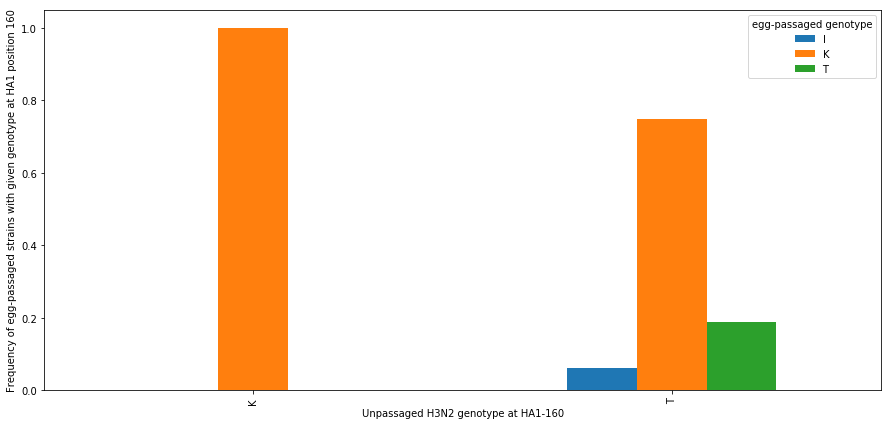

In [453]:
#Plot 160 mutations separated by unpassaged genotype
fig, ax = plt.subplots(figsize=(15,7))

fig = match_df.groupby('159-unpassaged')['159-egg'].value_counts(normalize=True).unstack().plot(kind='bar', ax=ax)
plt.xlabel('Unpassaged H3N2 genotype at HA1-160')
plt.ylabel('Frequency of egg-passaged strains with given genotype at HA1 position 160')
plt.legend(title='egg-passaged genotype')


In [454]:
match_df.groupby('159-unpassaged')['159-egg'].value_counts(normalize=True)

159-unpassaged  159-egg
K               K          1.0000
T               K          0.7500
                T          0.1875
                I          0.0625
Name: 159-egg, dtype: float64